# BRISQUE score

## single image

In [1]:
#BRISQUE
#Blind/Referenceless Image Spatial Quality Evaluator
#Single number score for image quality (to facilitate comparing photos and selecting 'best' photo)

'''
add to requirements.txt !!!!!!! _> #pip install brisque
'''
#pip install brisque

from PIL import Image
import numpy as np
from brisque import BRISQUE

# Load the image using PIL
image_path = '/home/gregrevill/code/GregRevFr/photopocalypse/raw_data/input_images/DSC_0797.JPG'
image = Image.open(image_path)

# Convert the image to RGB (if it's not already)
image = image.convert('RGB')

# Convert the image to a numpy array
image_array = np.array(image)

# Calculate the BRISQUE score
brisque_score = BRISQUE().score(image_array)

print(f"BRISQUE score for the image is: {brisque_score}")

#For Image via URL :
#obj = BRISQUE(url=True).score("https://images.ctfassets.net/u4vv676b8z52/4dy4qSI9G77nmLayGrUl73/08fdde4d35a717c7e9d123ef2a478e9b/blurred-vision-678x446_compressed.jpg?fm=jpg&q=80")


BRISQUE score for the image is: 37.70387223966097


## BRISQUE score for multiple images in a folder (with error avoidance code)

In [4]:
import os
from PIL import Image
import numpy as np
from brisque import BRISQUE
import pandas as pd

# Function to process a single image
def process_image(image_file):
    # Construct the full image path
    image_path = os.path.join(image_dir, image_file)

    # Check if the path is a file and is a recognized image format
    if os.path.isfile(image_path) and image_file.lower().endswith(('.png', '.jpg', '.jpeg')):
        try:
            # Load the image using PIL
            image = Image.open(image_path)

            # Convert the image to RGB (if it's not already)
            image = image.convert('RGB')

            # Resize the image
            image = image.resize((256, 256))

            # Convert the image to a numpy array
            image_array = np.array(image)

            # Calculate the BRISQUE score
            brisque_score = BRISQUE().score(image_array)

            return (image_file, brisque_score)
        except Exception as e:
            print(f"Error processing file {image_file}: {e}")

# Directory containing the images
image_dir = "/home/gregrevill/code/GregRevFr/photopocalypse/raw_data/input_images/"

# List all the files in the directory
image_files = os.listdir(image_dir)

# Initialize a list to store the results
results = []

# Process each image file
for image_file in image_files:
    result = process_image(image_file)
    if result is not None:
        results.append(result)

# Convert the results to a pandas DataFrame
df = pd.DataFrame(results, columns=['Image', 'BRISQUE Score'])

# Display the DataFrame
print(df)


                                  Image  BRISQUE Score
0               IMG_20221112_114055.jpg       8.967710
1               IMG_20200830_122836.jpg      14.735256
2               IMG_20220925_181508.jpg      23.356438
3                    Photopocolypse.png       8.537720
4                          DSC_0949.JPG       2.928221
5                Photopocalypse WBG.png      38.680168
6                          IMG_3273.jpg      24.888505
7                          DSC_0797.JPG      14.092193
8               IMG_20220925_002424.jpg      28.729476
9   PXL_20201224_184804134.PORTRAIT.jpg      -2.753068
10            IMG_20221112_143423_1.jpg      20.663512
11              IMG_20221112_144827.jpg       6.225910
12              IMG_20220709_090139.jpg      21.545304
13                         IMG_1606.JPG      17.999893


In [5]:
df.to_csv('/home/gregrevill/code/GregRevFr/photopocalypse/raw_data/brisque_scores2.csv')


# Deblur tiling photo attempt

In [11]:
'''
Model to deblur images, using EDSR.
takes image from EDI
    nparr = np.frombuffer(contents, np.uint8)
    image = cv2.imdecode(nparr, cv2.IMREAD_COLOR)
if the input image is larger than 768x768 then it scales the image down so longest side is 768 pixels,
then pads short side to reach 768 pixels,
then splits padded image into 9 tiles,
process each tile individually,
then reconstruct the enhanced image from the enhanced patches
and remove padding from the enhanced image.
'''

import tensorflow as tf
from tensorflow.keras.models import load_model
import numpy as np
import cv2

model_path = '/home/gregrevill/code/GregRevFr/photopocalypse/models/SRresnet.h5'
image_path = '/home/gregrevill/code/GregRevFr/photopocalypse/raw_data/input_images/DSC_0797.JPG'
model = load_model(model_path)
tile_size = 256
number_of_tiles = 9

def deblur_image(image_path):
    # Load the image
    image = cv2.imread(image_path)

    # Save the original dimensions
    original_height, original_width = image.shape[:2]

    # Resize if larger than 768x768
    max_side = tile_size * int(number_of_tiles ** 0.5)
    scale_factor = min(max_side / image.shape[0], max_side / image.shape[1])
    if scale_factor < 1:
        new_size = (int(image.shape[1] * scale_factor), int(image.shape[0] * scale_factor))
        image = cv2.resize(image, new_size, interpolation=cv2.INTER_AREA)

    # Padding
    pad_height = (tile_size - image.shape[0] % tile_size) % tile_size
    pad_width = (tile_size - image.shape[1] % tile_size) % tile_size
    image = cv2.copyMakeBorder(image, 0, pad_height, 0, pad_width, cv2.BORDER_CONSTANT, value=0)

    # Split into tiles
    tiles = []
    for i in range(0, image.shape[0], tile_size):
        for j in range(0, image.shape[1], tile_size):
            tile = image[i:i + tile_size, j:j + tile_size]
            tiles.append(tile)

    # Predict and enhance each tile
    enhanced_tiles = [model.predict(np.expand_dims(tile, 0))[0] for tile in tiles]

    # Reconstruct the enhanced image
    rows = []
    for i in range(0, len(enhanced_tiles), int(image.shape[1] / tile_size)):
        rows.append(np.hstack(enhanced_tiles[i:i + int(image.shape[1] / tile_size)]))
    enhanced_image = np.vstack(rows)

    # Remove padding
    enhanced_image = enhanced_image[:original_height, :original_width]
    return enhanced_image

# Deblur the image
image_path = '/home/gregrevill/code/GregRevFr/photopocalypse/raw_data/input_images/DSC_0797.JPG'
enhanced_image = deblur_image(image_path)

# Save the enhanced image
cv2.imwrite('enhanced_image.jpg', enhanced_image)


1/1 [==============================] - 2s 2s/step


True

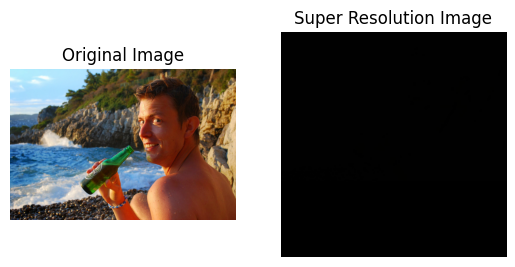

In [12]:
# display original image and super resolution image side by side with labels

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load the images
img1 = mpimg.imread('/home/gregrevill/code/GregRevFr/photopocalypse/raw_data/input_images/DSC_0797.JPG')
img2 = mpimg.imread('enhanced_image.jpg')

# Create a figure with two subplots
fig, ax = plt.subplots(1, 2)

# Display the images
ax[0].imshow(img1)
ax[0].set_title('Original Image')
ax[0].axis('off')

ax[1].imshow(img2)
ax[1].set_title('Super Resolution Image')
ax[1].axis('off')

# Show the figure
plt.show()
